## Srinagar DWR Beam Blockage

Author: [Hamid Ali Syed](https://syedha.com)

In [1]:
import pandas as pd
from metpy.units import units
from metpy import constants
import metpy.calc as calc

In [2]:
url = "https://wrd.mgm.gov.tr/Radar/Details/RFJiNTBvSnFCeEdzelZlRmJKL2VTQT09"
tables = pd.read_html(url)

# Assuming the table you're interested in is the first one
table = tables[0]

In [3]:
display(table)

,0,1,2,3
0,Radar name,DWR Srinagar,Country,356 - India
1,WSI code,0-21010-0-699,Station operating status,Operational
2,Supervising organization,India Meteorological Department,Station Type,Land (fixed)
3,Installation date,2017-11-27,Region of origin of data,Asia
4,Latitude,34.0572,Longitude,74.8133
5,Elevation,1588m,Tower height,15
6,Owner name,IMD,Manufacturer,NaN
7,Time zone,Asia/Kolkata,Spatial extent,Volume
8,Communication method,NaN,Frequency Band,X
9,Frequency,9375,Beam width,1.00


In [4]:
radar_lat = 34.0572
radar_lon = 74.8133
radar_alt = 1588 * units('m')
radar_freq = 9375 * units('MHz')
radar_range = 100e3 * units('m')
radar_bw = 1.0 * units('degree')
tower_height = 15 * units('m')
total_ele = radar_alt + tower_height

In [5]:
c = 3e8 * units('m/s')
wl = c / radar_freq
wl.to_base_units()

0.032 <Unit('meter')>

In [6]:
def calc_rmax(prf):
    c = 3e8
    return c / (2 * prf)

In [7]:
max_range = str(round(calc_rmax(1075)/1e3, 2))
print(f'{max_range} km')

139.53 km


In [8]:
import wradlib as wrl
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()
import numpy as np

0.3.0


In [9]:
sitecoords = (radar_lon, radar_lat, total_ele.m)
nrays = 360  # number of rays
nbins = 1000  # number of range bins
el = 0.5  # vertical antenna pointing angle (deg)
bw = 1.0  # half power beam width (deg)
range_res = 100.0  # range resolution (meters)

In [10]:
def plot_beam_blockage(sitecoords=(radar_lon, radar_lat, total_ele.m),
                       nrays=360, nbins=1000,
                       el=1, bw=1.0, range_res=100, azimuth_ang=220):
    r = np.arange(nbins) * range_res
    beamradius = wrl.util.half_power_radius(r, bw)

    coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
    coords = wrl.georef.spherical_to_proj(
        coord[..., 0], coord[..., 1], coord[..., 2], sitecoords
    )
    lon = coords[..., 0]
    lat = coords[..., 1]
    alt = coords[..., 2]

    polcoords = coords[..., :2]
    print("lon,lat,alt:", coords.shape)

    rlimits = (lon.min(), lat.min(), lon.max(), lat.max())
    print(
        "Radar bounding box:\n\t%.2f\n%.2f             %.2f\n\t%.2f"
        % (lat.max(), lon.min(), lon.max(), lat.min())
    )

    ds = wrl.io.open_raster("JKL_DEM/merged_dem.tif")
    rastervalues, rastercoords, crs = wrl.georef.extract_raster_dataset(ds, nodata=-32768.0)

    # Clip the region inside our bounding box
    ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
    rastercoords = rastercoords[ind[1] : ind[3], ind[0] : ind[2], ...]
    rastervalues = rastervalues[ind[1] : ind[3], ind[0] : ind[2]]

    # Map rastervalues to polar grid points
    polarvalues = wrl.ipol.cart_to_irregular_spline(
        rastercoords, rastervalues, polcoords, order=3, prefilter=False
    )

    PBB = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
    PBB = np.ma.masked_invalid(PBB)
    print(PBB.shape)

    CBB = wrl.qual.cum_beam_block_frac(PBB)
    print(CBB.shape)

    # just a little helper function to style x and y axes of our maps
    def annotate_map(ax, cm=None, title=""):
        ticks = (ax.get_xticks() / 1000).astype(int)
        ax.set_xticklabels(ticks)
        ticks = (ax.get_yticks() / 1000).astype(int)
        ax.set_yticklabels(ticks)
        ax.set_xlabel("Kilometers")
        ax.set_ylabel("Kilometers")
        if not cm is None:
            plt.colorbar(cm, ax=ax)
        if not title == "":
            ax.set_title(title)
        ax.grid()

    fig = plt.figure(figsize=(15, 12))

    # create subplots
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

    # azimuth angle
    angle = azimuth_ang


    # Plot terrain (on ax1)
    polarvalues = wrl.georef.create_xarray_dataarray(
        polarvalues, r=r, phi=coord[:, 0, 1]
    ).wrl.georef.georeference()
    dem = polarvalues.wrl.vis.plot(ax=ax1, cmap=mpl.cm.terrain, vmin=0.0, add_colorbar=False)
    ax1.plot(
        [0, np.sin(np.radians(angle)) * 1e5], [0, np.cos(np.radians(angle)) * 1e5], "r-"
    )
    ax1.plot(sitecoords[0], sitecoords[1], "ro")
    annotate_map(ax1, dem, "Terrain within {0} km range".format(np.max(r / 1000.0) + 0.1))

    # Plot CBB (on ax2)
    CBB = wrl.georef.create_xarray_dataarray(
        CBB, r=r, phi=coord[:, 0, 1]
    ).wrl.georef.georeference()
    cbb = CBB.wrl.vis.plot(ax=ax2, cmap=mpl.cm.PuRd, vmin=0, vmax=1, add_colorbar=False)
    annotate_map(ax2, cbb, "Beam-Blockage Fraction")

    # Plot single ray terrain profile on ax3
    (bc,) = ax3.plot(r / 1000.0, alt[angle, :], "-b", linewidth=3, label="Beam Center")
    (b3db,) = ax3.plot(
        r / 1000.0,
        (alt[angle, :] + beamradius),
        ":b",
        linewidth=1.5,
        label="3 dB Beam width",
    )
    ax3.plot(r / 1000.0, (alt[angle, :] - beamradius), ":b")
    ax3.fill_between(r / 1000.0, 0.0, polarvalues[angle, :], color="0.75")
    ax3.set_xlim(0.0, np.max(r / 1000.0) + 0.1)
    # ax3.set_ylim(0.0, 5000)
    ax3.set_xlabel("Range (km)")
    ax3.set_ylabel("Altitude (m)")
    ax3.grid()

    axb = ax3.twinx()
    (bbf,) = axb.plot(r / 1000.0, CBB[angle, :], "-k", label="BBF")
    axb.set_ylabel("Beam-blockage fraction")
    axb.set_ylim(0.0, 1.0)
    # axb.set_xlim(0.0, np.max(r / 1000.0) + 0.1)


    legend = ax3.legend(
        (bc, b3db, bbf),
        ("Beam Center", "3 dB Beam width", "BBF"),
        loc="upper left",
        fontsize=10,
    )

    def height_formatter(x, pos):
        x = (x - 6370000) / 1000
        fmt_str = "{:g}".format(x)
        return fmt_str


    def range_formatter(x, pos):
        x = x / 1000.0
        fmt_str = "{:g}".format(x)
        return fmt_str

    fig = plt.figure(figsize=(10, 6))

    cgax, caax, paax = wrl.vis.create_cg(fig=fig, rot=0, scale=1)

    # azimuth angle
    angle = azimuth_ang

    # fix grid_helper
    er = 6370000
    gh = cgax.get_grid_helper()
    gh.grid_finder.grid_locator2._nbins = 80
    gh.grid_finder.grid_locator2._steps = [1, 2, 4, 5, 10]

    # calculate beam_height and arc_distance for ke=1
    # means line of sight
    bhe = wrl.georef.bin_altitude(r, 0, sitecoords[2], re=er, ke=1.0)
    ade = wrl.georef.bin_distance(r, 0, sitecoords[2], re=er, ke=1.0)
    nn0 = np.zeros_like(r)
    # for nice plotting we assume earth_radius = 6370000 m
    ecp = nn0 + er
    # theta (arc_distance sector angle)
    thetap = -np.degrees(ade / er) + 90.0

    # zero degree elevation with standard refraction
    bh0 = wrl.georef.bin_altitude(r, 0, sitecoords[2], re=er)

    # plot (ecp is earth surface normal null)
    (bes,) = paax.plot(thetap, ecp, "-k", linewidth=3, label="Earth Surface NN")
    (bc,) = paax.plot(thetap, ecp + alt[angle, :], "-b", linewidth=3, label="Beam Center")
    (bc0r,) = paax.plot(
        thetap, ecp + bh0 + alt[angle, 0] - sitecoords[2], "-g", label="0 deg Refraction"
    )
    (bc0n,) = paax.plot(
        thetap, ecp + bhe + alt[angle, 0] - sitecoords[2], "-r", label="0 deg line of sight"
    )
    (b3db,) = paax.plot(
        thetap, ecp + alt[angle, :] + beamradius, ":b", label="+3 dB Beam width"
    )
    paax.plot(thetap, ecp + alt[angle, :] - beamradius, ":b", label="-3 dB Beam width")

    # orography
    paax.fill_between(thetap, ecp, ecp + polarvalues[angle, :], color="0.75")

    # shape axes
    cgax.set_xlim(0, np.max(ade))
    cgax.set_ylim([ecp.min() - 1000, ecp.max() + 5000])
    caax.grid(True, axis="x")
    cgax.grid(True, axis="y")
    cgax.axis["top"].toggle(all=False)
    caax.yaxis.set_major_locator(
        mpl.ticker.MaxNLocator(steps=[1, 2, 4, 5, 10], nbins=20, prune="both")
    )
    caax.xaxis.set_major_locator(mpl.ticker.MaxNLocator())
    caax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(height_formatter))
    caax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(range_formatter))

    caax.set_xlabel("Range (km)")
    caax.set_ylabel("Altitude (km)")

    legend = paax.legend(
        (bes, bc0n, bc0r, bc, b3db),
        (
            "Earth Surface NN",
            "0 deg line of sight",
            "0 deg std refraction",
            "Beam Center",
            "3 dB Beam width",
        ),
        loc="upper left",
        fontsize=10,
    )

lon,lat,alt: (360, 1000, 3)
Radar bounding box:
	34.96
73.73             75.90
	33.16
(360, 1000)
(360, 1000)


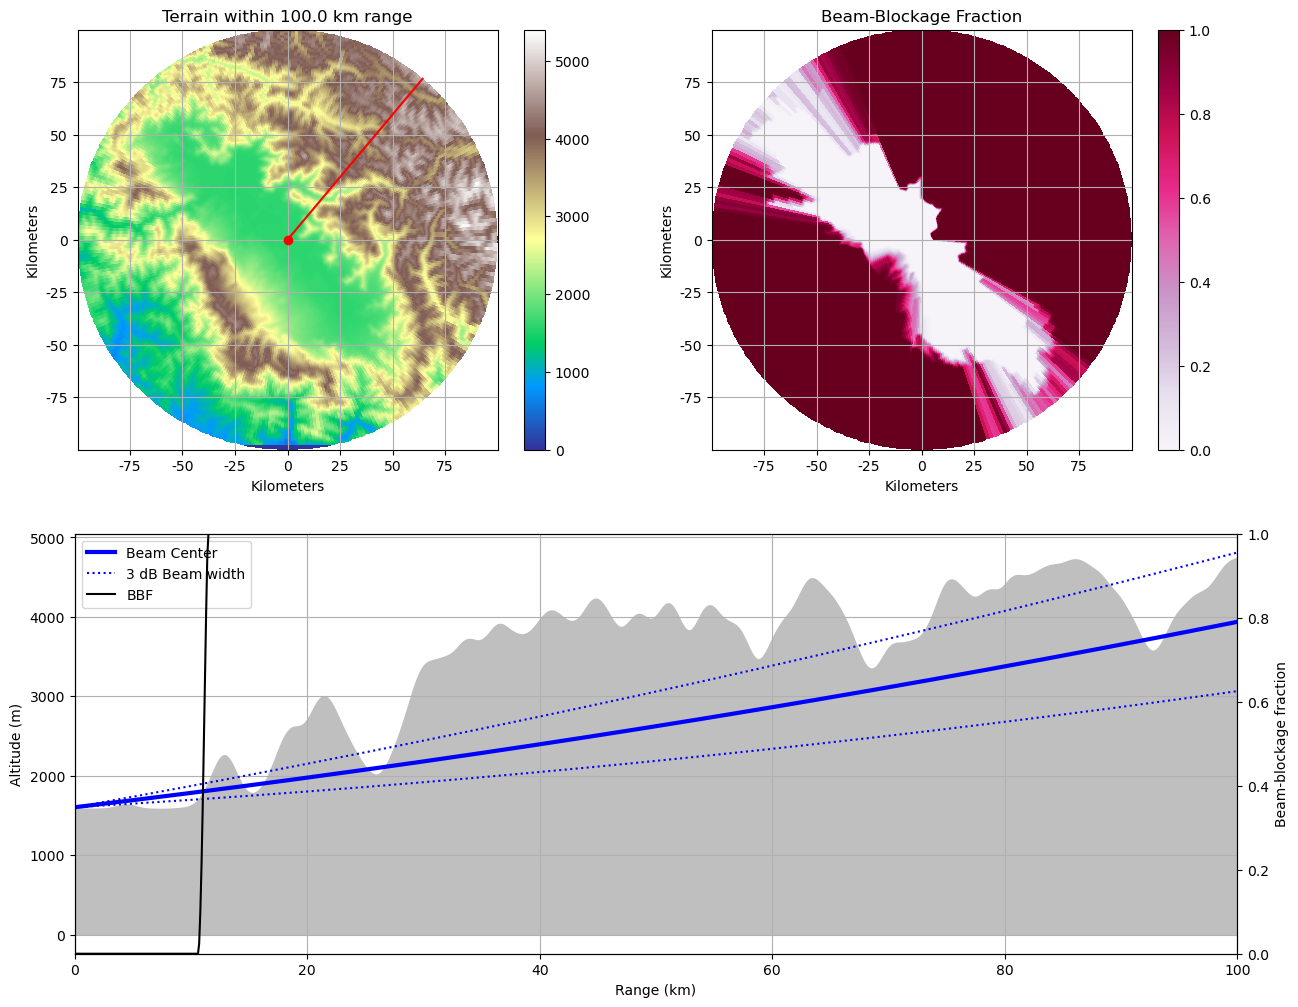

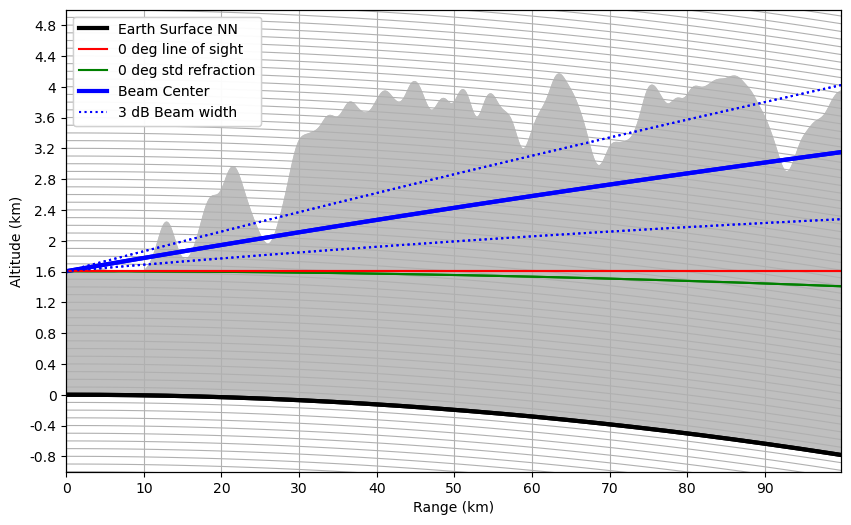

In [11]:
plot_beam_blockage(el=1.0, azimuth_ang=(220+180)%360)

lon,lat,alt: (360, 1000, 3)
Radar bounding box:
	34.96
73.73             75.89
	33.16
(360, 1000)
(360, 1000)


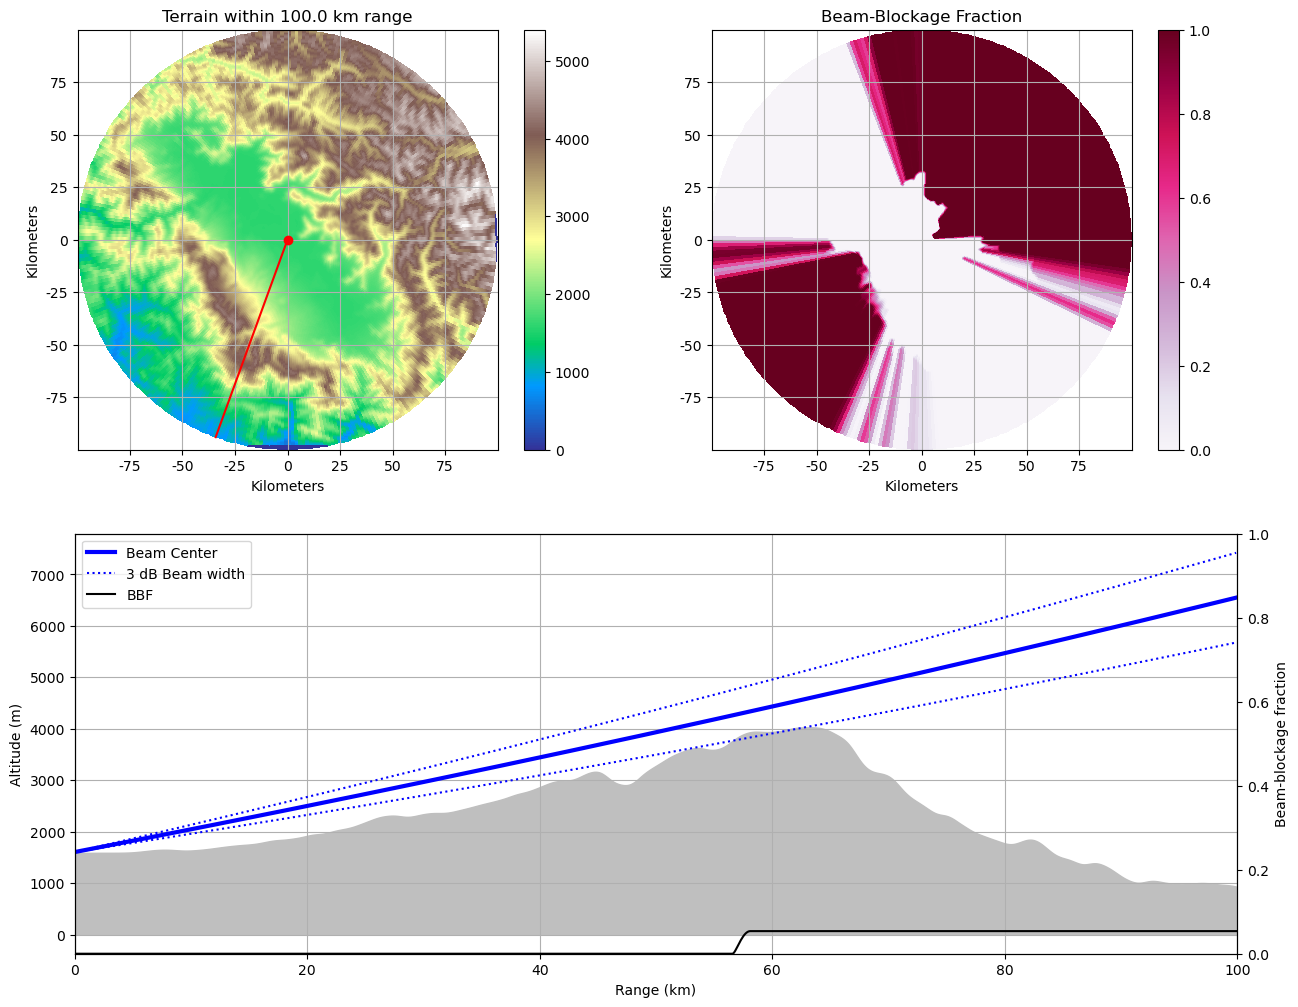

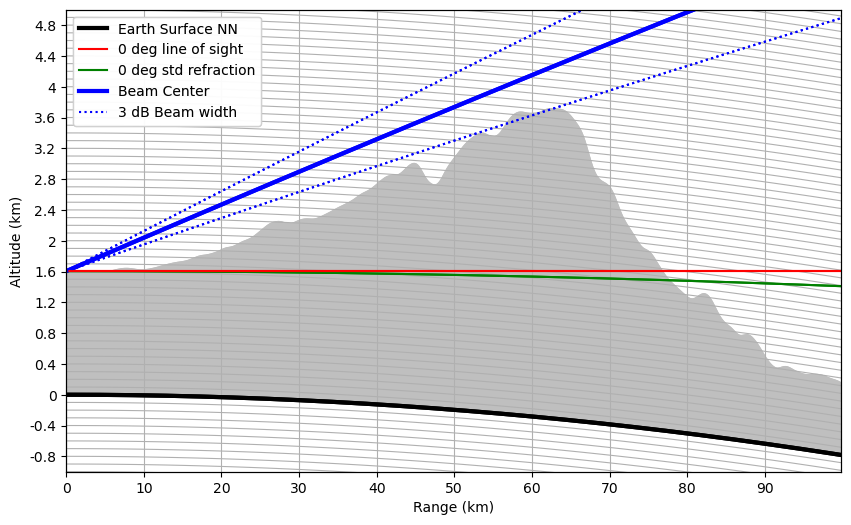

In [14]:
plot_beam_blockage(el=2.5, azimuth_ang=200)

Thank you! <br>
*–Hamid*